In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [35]:
ativos = ["WEGE3.SA","ITUB4.SA","POMO4.SA","EMBR3.SA","DIRR3.SA",
          "EQTL3.SA","BPAC11.SA","AURA33.SA","AAPL","MSFT","NVDA",
          "LHX","JPM","RHM.DE"]  # exemplo

# Download dos preços
precos = yf.download(ativos, start="2006-01-01", end="2024-12-31")["Close"]

# Ajustar preços antes do IPO (mantém o primeiro preço até a data inicial)
for ativo in precos.columns:
    primeira_data = precos[ativo].first_valid_index()
    if primeira_data is not None:
        precos.loc[:primeira_data, ativo] = precos.loc[primeira_data, ativo]

# Calcular retornos (zerados antes do IPO)
retornos = precos.pct_change().fillna(0)

# Divisão treino / teste
metade = len(retornos) // 2
retornos_treino = retornos.iloc[:metade].copy()
retornos_teste = retornos.iloc[metade:].copy()

# Parâmetros da simulação
num_ativos = len(retornos.columns)
num_carteiras_simuladas = 30000

C:\Users\Oitech\AppData\Local\Temp\ipykernel_4376\285030354.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  precos = yf.download(ativos, start="2006-01-01", end="2024-12-31")["Close"]
[*********************100%***********************]  14 of 14 completed
C:\Users\Oitech\AppData\Local\Temp\ipykernel_4376\285030354.py:15: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  retornos = precos.pct_change().fillna(0)


In [37]:
def desempenho_portfolio(pesos, retornos, taxa_livre_risco=0.06):
    retorno_portfolio = np.dot(pesos, retornos.mean()) * 252
    volatilidade_portfolio = np.sqrt(np.dot(pesos.T, np.dot(retornos.cov() * 252, pesos)))
    sharpe_ratio = (retorno_portfolio - taxa_livre_risco) / volatilidade_portfolio

    return {
        "retorno": retorno_portfolio,
        "volatilidade": volatilidade_portfolio,
        "sharpe_ratio": sharpe_ratio
    }

def desempenho_portfolio_treino(pesos, retornos_treino, taxa_livre_risco=0.06):
    return desempenho_portfolio(pesos, retornos_treino, taxa_livre_risco)

def desempenho_portfolio_real(pesos, retornos_teste, taxa_livre_risco=0.06):
    return desempenho_portfolio(pesos, retornos_teste, taxa_livre_risco)

In [39]:
resultados_treino = []
pesos_treino_df = pd.DataFrame()

for _ in range(num_carteiras_simuladas):
    pesos = pd.Series(np.random.random(num_ativos), index=retornos_treino.columns)
    pesos = pesos / pesos.sum()

    metrica = desempenho_portfolio_treino(pesos, retornos_treino)
    resultados_treino.append(metrica)

    pesos_treino_df = pd.concat([pesos_treino_df, pesos.to_frame().T], ignore_index=True)

df_treino = pd.DataFrame(resultados_treino)

In [41]:
resultados_teste = []
pesos_teste_df = pd.DataFrame()

for _, pesos in pesos_treino_df.iterrows():
    metrica = desempenho_portfolio_real(pesos, retornos_teste)
    resultados_teste.append(metrica)

    pesos_teste_df = pd.concat([pesos_teste_df, pesos.to_frame().T], ignore_index=True)

df_teste = pd.DataFrame(resultados_teste)

In [43]:
# Parâmetro
R2_THRESHOLD = 0.3
# Taxa livre de risco anual
TAXA_LIVRE_RISCO_ANUAL = 0.06

# ---------- 0) checagens rápidas e padronização ----------
if 'df_treino' not in globals() or 'df_teste' not in globals() or 'pesos_treino_df' not in globals():
    raise RuntimeError("As variáveis df_treino, df_teste e pesos_treino_df precisam existir antes de rodar este bloco.")

if len(df_treino) != len(df_teste) or len(df_treino) != len(pesos_treino_df):
    raise RuntimeError(f"df_treino, df_teste e pesos_treino_df precisam ter o mesmo número de linhas.")

def _standardize_columns(df):
    mapping = {}
    for c in df.columns:
        lc = c.lower()
        if 'ret' in lc and 'sharpe' not in lc:
            mapping[c] = 'retorno'
        elif 'vol' in lc or 'volatil' in lc:
            mapping[c] = 'volatilidade'
        elif 'sharpe' in lc:
            mapping[c] = 'sharpe_ratio'
    return df.rename(columns=mapping)

df_treino = _standardize_columns(df_treino)
df_teste = _standardize_columns(df_teste)

for name, df in [('df_treino', df_treino), ('df_teste', df_teste)]:
    for col in ('retorno', 'volatilidade'):
        if col not in df.columns:
            raise RuntimeError(f"{name} precisa conter a coluna '{col}'. Colunas atuais: {list(df.columns)}")

# ---------- 1) Calcular a diferença (consistência) entre treino e teste por carteira ----------
# Usamos a diferença de Sharpe Ratio, pois ele já combina retorno e risco
df_treino['sharpe_ratio'] = (df_treino['retorno'] - TAXA_LIVRE_RISCO_ANUAL) / df_treino['volatilidade']
df_teste['sharpe_ratio'] = (df_teste['retorno'] - TAXA_LIVRE_RISCO_ANUAL) / df_teste['volatilidade']

# Remover valores inválidos para o cálculo da diferença
df_treino['sharpe_ratio'] = df_treino['sharpe_ratio'].replace([np.inf, -np.inf], np.nan)
df_teste['sharpe_ratio'] = df_teste['sharpe_ratio'].replace([np.inf, -np.inf], np.nan)

# Calcular a diferença absoluta do Sharpe Ratio
sharpe_diff = (df_treino['sharpe_ratio'] - df_teste['sharpe_ratio']).abs()

# ---------- 2) Aplicar filtro de consistência ----------
# Carteiras com uma pequena diferença de Sharpe Ratio são consideradas consistentes
mask_selected = sharpe_diff <= R2_THRESHOLD
selected_count = int(mask_selected.sum())

print(f"Total de carteiras: {len(sharpe_diff)} | Carteiras selecionadas por consistência (Sharpe): {selected_count}")

if selected_count == 0:
    print("Nenhuma carteira passou no filtro. Não é possível selecionar a melhor.")
else:
    # ---------- 3) Selecionar a melhor carteira entre as filtradas ----------
    sharpe_teste_selected = df_teste['sharpe_ratio'].loc[mask_selected].dropna()

    if len(sharpe_teste_selected) == 0:
        print("Após remoção de valores inválidos, não restaram carteiras válidas para cálculo de Sharpe.")
    else:
        best_index = sharpe_teste_selected.idxmax()
        best_sharpe_value = sharpe_teste_selected.loc[best_index]

        print(f"Carteira selecionada (melhor Sharpe entre filtradas): índice = {best_index}, Sharpe (teste) = {best_sharpe_value:.6f}")

        if best_index in pesos_treino_df.index:
            best_weights = pesos_treino_df.loc[best_index]
        else:
            best_weights = pesos_treino_df.iloc[int(best_index)]

Total de carteiras: 30000 | Carteiras selecionadas por consistência (Sharpe): 18
Carteira selecionada (melhor Sharpe entre filtradas): índice = 13668, Sharpe (teste) = 0.913293


In [45]:
idx_max_sharpe = df_teste["sharpe_ratio"].idxmax()
idx_min_risco = df_teste["volatilidade"].idxmin()
idx_max_risco = df_teste["volatilidade"].idxmax()
idx_max_retorno = df_teste["retorno"].idxmax()

carteiras_destaque = {
    "Máximo Sharpe Ratio": idx_max_sharpe,
    "Mínima Volatilidade": idx_min_risco,
    "Máxima Volatilidade": idx_max_risco,
    "Máximo Retorno": idx_max_retorno
}

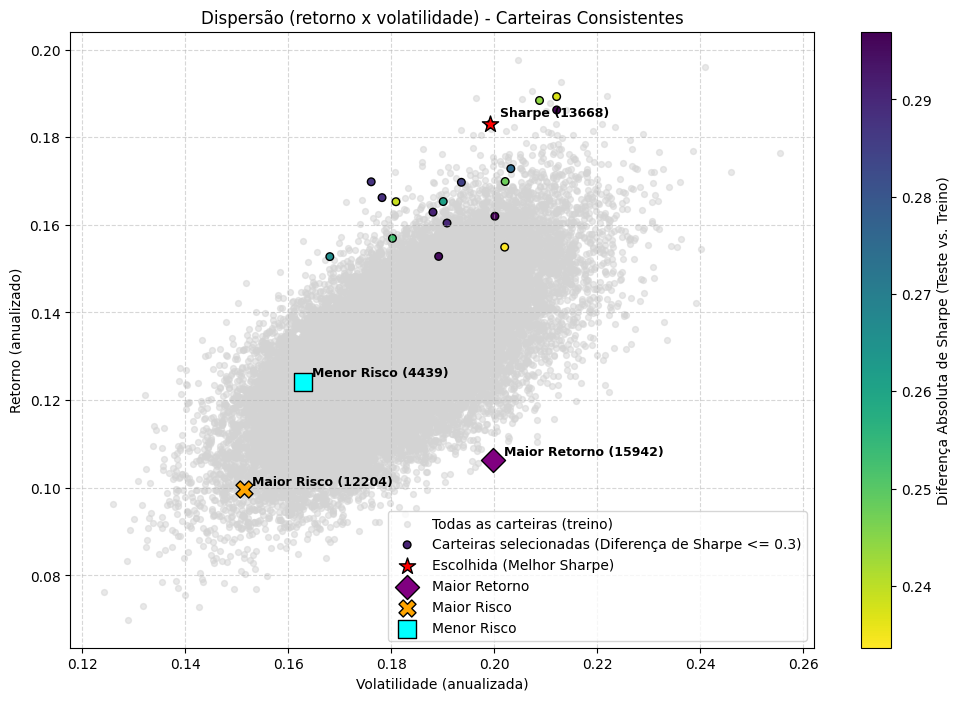

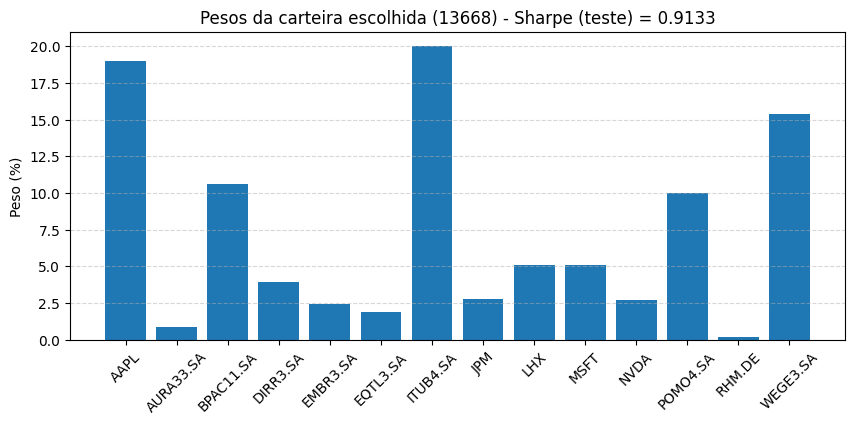

In [47]:
# Certifique-se de que a série `sharpe_diff` foi criada no bloco anterior
if 'sharpe_diff' not in globals():
    print("Por favor, execute o bloco de código anterior para calcular a consistência das carteiras (sharpe_diff).")
else:
    # --- 1. Gráfico de Dispersão com Filtro de Consistência ---
    plt.figure(figsize=(12, 8))
    
    # Plotar todas as carteiras de treino (plot base)
    plt.scatter(df_treino['volatilidade'], df_treino['retorno'],
                c='lightgray', alpha=0.5, s=18, label='Todas as carteiras (treino)')
    
    # Plotar as carteiras selecionadas com a cor baseada na diferença de Sharpe
    scatter = plt.scatter(df_treino.loc[mask_selected, 'volatilidade'],
                          df_treino.loc[mask_selected, 'retorno'],
                          c=sharpe_diff.loc[mask_selected], cmap='viridis_r', s=30, edgecolors='k',
                          label=f'Carteiras selecionadas (Diferença de Sharpe <= {R2_THRESHOLD})')
    
    cbar = plt.colorbar(scatter)
    cbar.set_label('Diferença Absoluta de Sharpe (Teste vs. Treino)')
    
    # Destaque da melhor carteira, plotada sobre os dados de TREINO
    plt.scatter(df_treino.loc[best_index, 'volatilidade'], df_treino.loc[best_index, 'retorno'],
                c='red', s=150, marker='*', edgecolors='black', zorder=6, label='Escolhida (Melhor Sharpe)')
    
    # Destaque da carteira de MAIOR RETORNO
    plt.scatter(df_treino.loc[idx_max_retorno, 'volatilidade'], df_treino.loc[idx_max_retorno, 'retorno'],
                c='purple', s=150, marker='D', edgecolors='black', zorder=6, label='Maior Retorno')
    
    # Destaque da carteira de MAIOR RISCO
    plt.scatter(df_treino.loc[idx_max_risco, 'volatilidade'], df_treino.loc[idx_max_risco, 'retorno'],
                c='orange', s=150, marker='X', edgecolors='black', zorder=6, label='Maior Risco')
    
    # Destaque da carteira de MENOR RISCO
    plt.scatter(df_treino.loc[idx_min_risco, 'volatilidade'], df_treino.loc[idx_min_risco, 'retorno'],
                c='cyan', s=150, marker='s', edgecolors='black', zorder=6, label='Menor Risco')
    
    # Adicionar as legendas de texto para as carteiras destacadas
    plt.text(df_treino.loc[best_index, 'volatilidade'] * 1.01,
             df_treino.loc[best_index, 'retorno'] * 1.01,
             f'Sharpe ({best_index})', fontsize=9, weight='bold')
    
    plt.text(df_treino.loc[idx_max_retorno, 'volatilidade'] * 1.01,
             df_treino.loc[idx_max_retorno, 'retorno'] * 1.01,
             f'Maior Retorno ({idx_max_retorno})', fontsize=9, weight='bold')
    
    plt.text(df_treino.loc[idx_max_risco, 'volatilidade'] * 1.01,
             df_treino.loc[idx_max_risco, 'retorno'] * 1.01,
             f'Maior Risco ({idx_max_risco})', fontsize=9, weight='bold')
    
    plt.text(df_treino.loc[idx_min_risco, 'volatilidade'] * 1.01,
             df_treino.loc[idx_min_risco, 'retorno'] * 1.01,
             f'Menor Risco ({idx_min_risco})', fontsize=9, weight='bold')
             
    plt.xlabel('Volatilidade (anualizada)')
    plt.ylabel('Retorno (anualizado)')
    plt.title(f'Dispersão (retorno x volatilidade) - Carteiras Consistentes')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # --- 2. Gráfico de Barras dos Pesos da Carteira Escolhida ---
    plt.figure(figsize=(10,4))
    best_weights_plot = best_weights.copy()
    plt.bar(best_weights_plot.index, best_weights_plot.values * 100)
    plt.xticks(rotation=45)
    plt.ylabel('Peso (%)')
    plt.title(f'Pesos da carteira escolhida ({best_index}) - Sharpe (teste) = {best_sharpe_value:.4f}')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

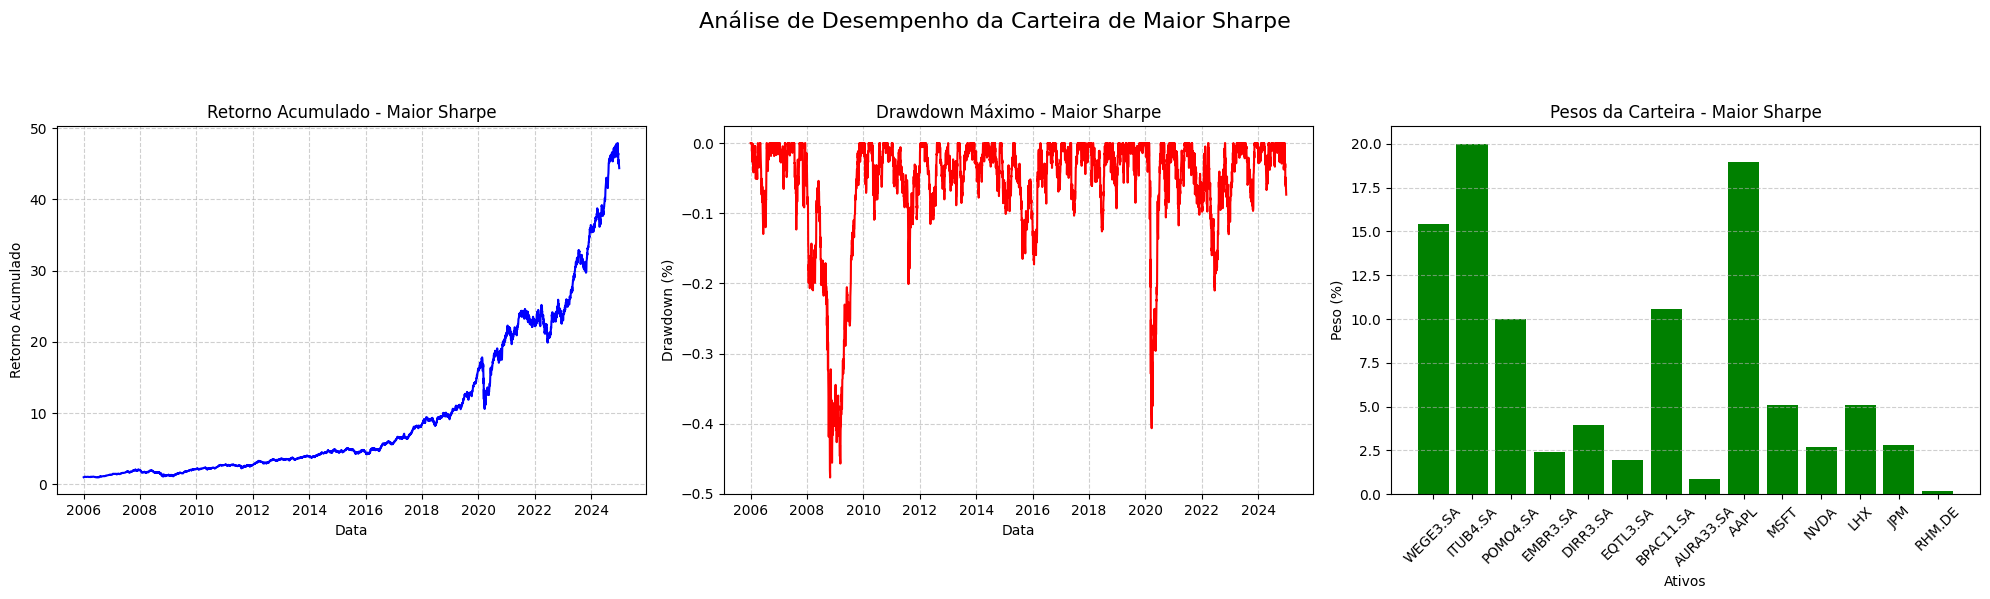

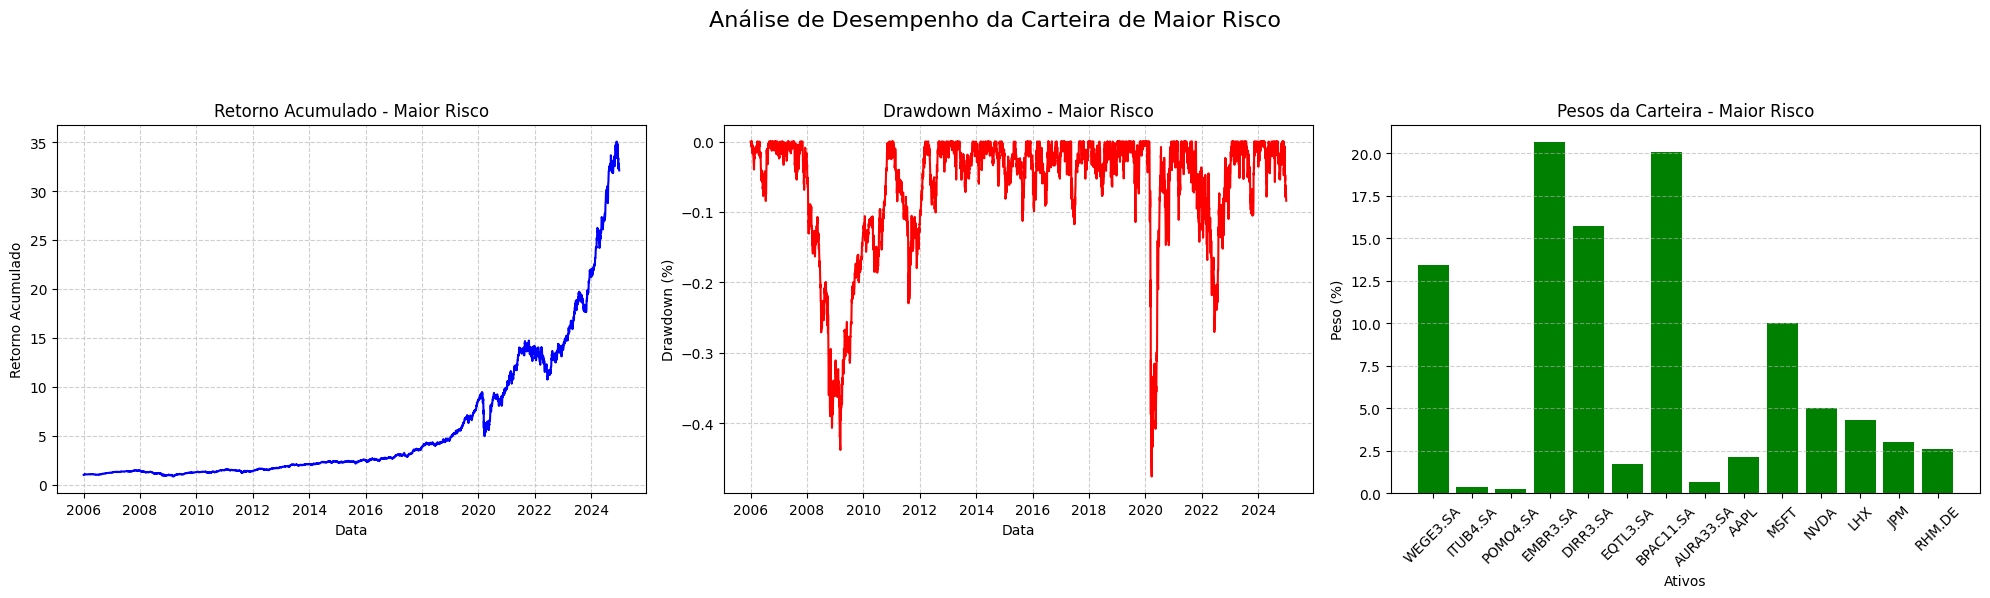

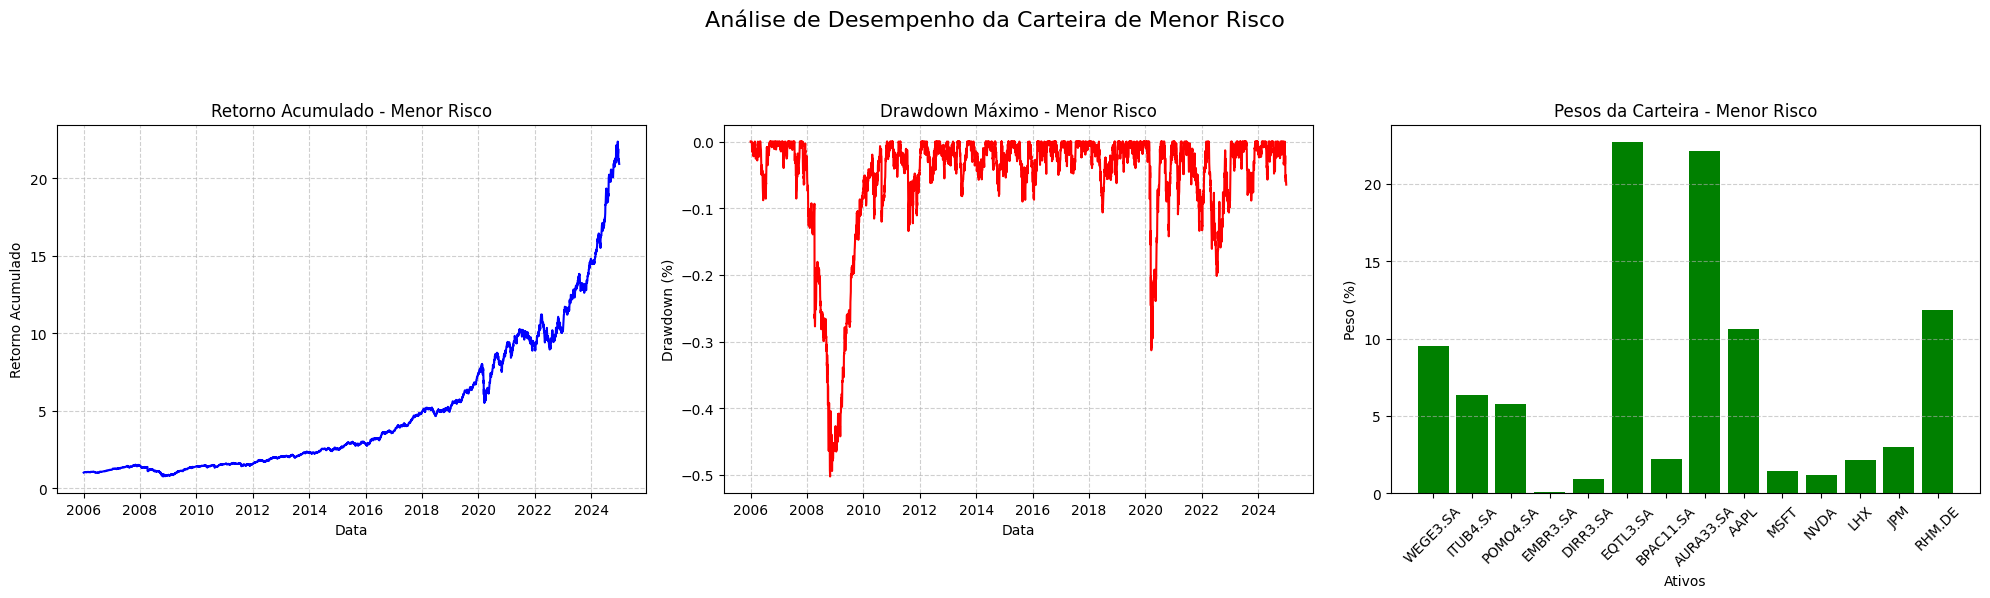

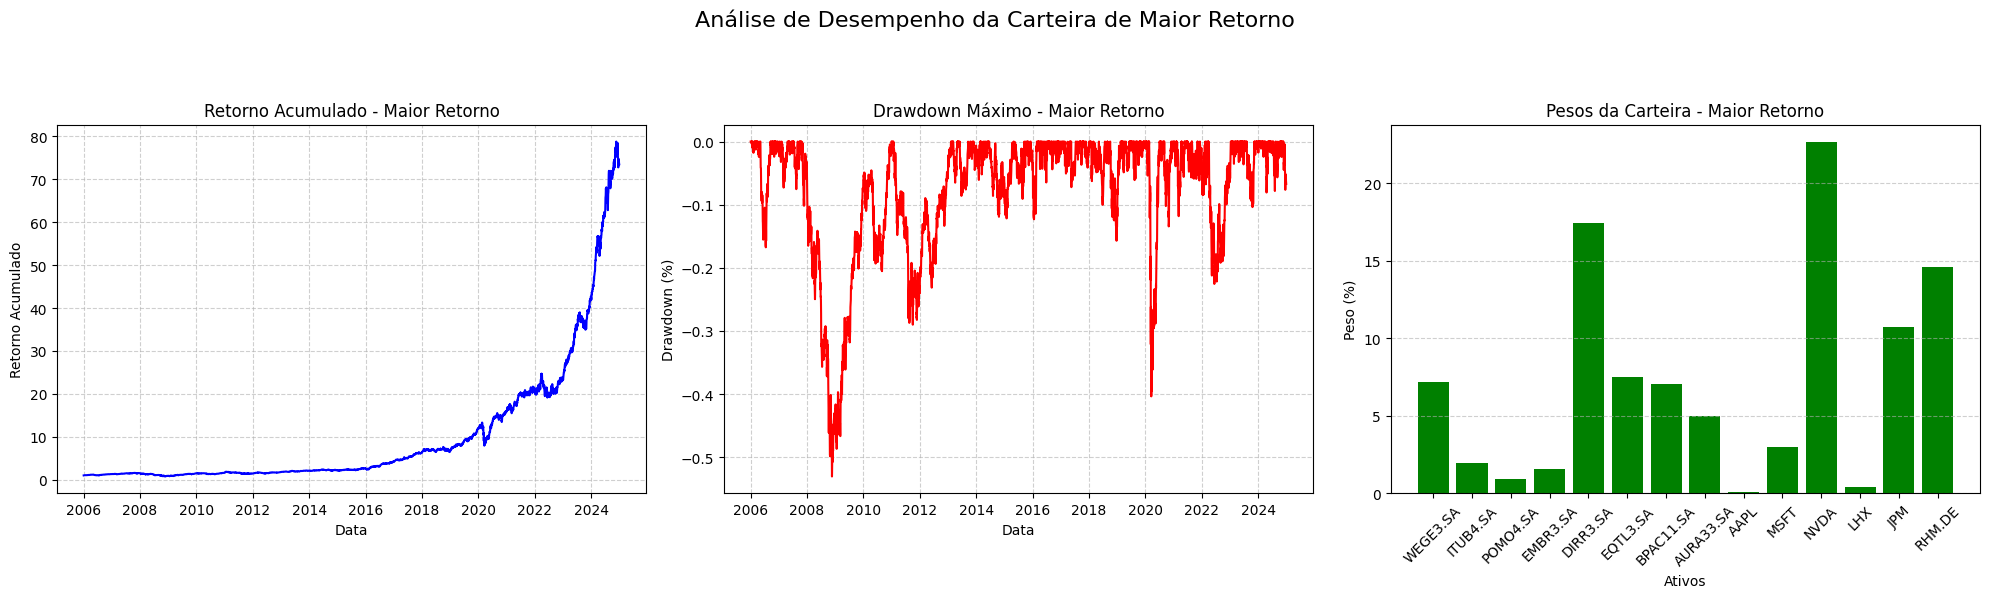

In [49]:
# --- 1. Encontrar o índice das carteiras de interesse ---
df_teste['sharpe_ratio'] = (df_teste['retorno'] - TAXA_LIVRE_RISCO_ANUAL) / df_teste['volatilidade']

idx_sharpe_max = best_index
idx_maior_risco = df_teste['volatilidade'].idxmax()
idx_menor_risco = df_teste['volatilidade'].idxmin()
idx_maior_retorno = df_teste['retorno'].idxmax()

carteiras_analise = {
    "Maior Sharpe": idx_sharpe_max,
    "Maior Risco": idx_maior_risco,
    "Menor Risco": idx_menor_risco,
    "Maior Retorno": idx_maior_retorno
}

# --- 2. Preparar os dados de retorno diário para o período completo ---
# Assumindo que 'ret_treino' e 'ret_teste' são os DataFrames de retornos diários
retornos_completos = pd.concat([retornos_treino, retornos_teste], axis=0)

# --- 3. Criar os gráficos para cada carteira ---
for label, idx in carteiras_analise.items():
    # Obter os pesos da carteira
    pesos_carteira = pesos_treino_df.loc[idx]
    
    # Calcular o retorno da carteira no período completo
    retorno_carteira_completo = (retornos_completos.loc[:, ativos] * pesos_carteira).sum(axis=1)
    
    # Calcular o retorno acumulado e o drawdown
    retorno_acumulado = (1 + retorno_carteira_completo).cumprod()
    drawdown = retorno_acumulado / retorno_acumulado.cummax() - 1

    # Iniciar a figura com 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    # Gráfico 1: Retorno Acumulado
    axs[0].plot(retorno_acumulado.index, retorno_acumulado, color='blue')
    axs[0].set_title(f'Retorno Acumulado - {label}')
    axs[0].set_xlabel('Data')
    axs[0].set_ylabel('Retorno Acumulado')
    axs[0].grid(True, linestyle='--', alpha=0.6)

    # Gráfico 2: Drawdown Máximo
    axs[1].plot(drawdown.index, drawdown, color='red')
    axs[1].set_title(f'Drawdown Máximo - {label}')
    axs[1].set_xlabel('Data')
    axs[1].set_ylabel('Drawdown (%)')
    axs[1].grid(True, linestyle='--', alpha=0.6)

    # Gráfico 3: Pesos dos Ativos
    pesos_series = pd.Series(pesos_carteira, index=ativos)
    axs[2].bar(pesos_series.index, pesos_series.values * 100, color='green')
    axs[2].set_title(f'Pesos da Carteira - {label}')
    axs[2].set_xlabel('Ativos')
    axs[2].set_ylabel('Peso (%)')
    axs[2].tick_params(axis='x', rotation=45)
    axs[2].grid(axis='y', linestyle='--', alpha=0.6)

    plt.suptitle(f'Análise de Desempenho da Carteira de {label}', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Representação do gráfico de Retornos no eixo y
 # n * o número no eixo y, ou seja, no eixo y 14 significa 140%

# Representação do gráfico de Drawdown no eixo y
 # no eixo y 0.3 significa 30%

In [51]:
idx_max_sharpe = df_treino["sharpe_ratio"].idxmax()
idx_min_volatilidade = df_treino["volatilidade"].idxmin()
idx_max_volatilidade = df_treino["volatilidade"].idxmax()
idx_max_retorno = df_treino["retorno"].idxmax()

carteiras_destaque = {
    "Máximo Sharpe Ratio": idx_max_sharpe,
    "Mínima Volatilidade": idx_min_volatilidade,
    "Máxima Volatilidade": idx_max_volatilidade,
    "Máximo Retorno": idx_max_retorno
}

In [53]:
modelo = LinearRegression()

X = df_treino["sharpe_ratio"].values.reshape(-1, 1)
y = df_teste["sharpe_ratio"].values

modelo.fit(X, y)

print("Coeficiente angular:", modelo.coef_[0])
print("Intercepto:", modelo.intercept_)
print("R² do modelo:", modelo.score(X, y))

Coeficiente angular: -0.09189189907753836
Intercepto: 1.1317416452321247
R² do modelo: 0.003875007327240332


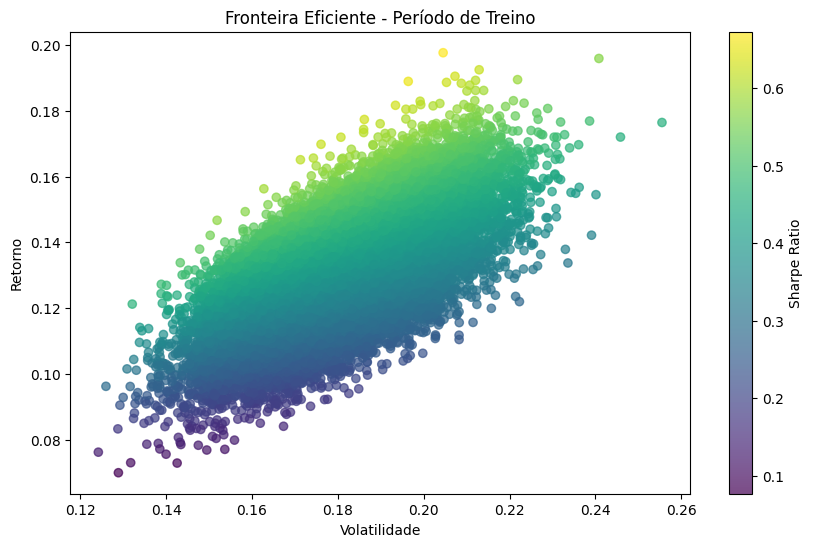

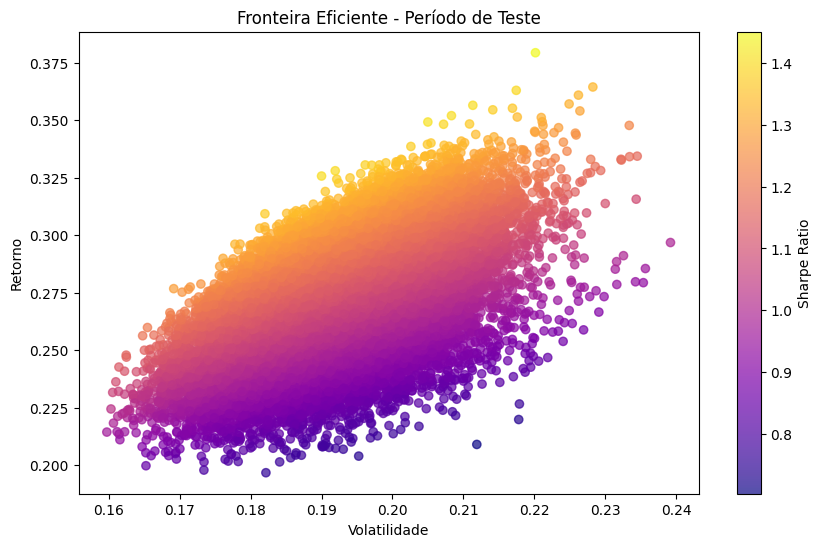

In [55]:
plt.figure(figsize=(10, 6))
plt.scatter(df_treino["volatilidade"], df_treino["retorno"], c=df_treino["sharpe_ratio"], cmap="viridis", alpha=0.7)
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Volatilidade")
plt.ylabel("Retorno")
plt.title("Fronteira Eficiente - Período de Treino")
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(df_teste["volatilidade"], df_teste["retorno"], c=df_teste["sharpe_ratio"], cmap="plasma", alpha=0.7)
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Volatilidade")
plt.ylabel("Retorno")
plt.title("Fronteira Eficiente - Período de Teste")
plt.show()

=== Resumo da Regressão (treino -> teste) ===
retorno: R² = 0.1009 | MSE = 0.000478976 | MAE = 0.0175444
volatilidade: R² = 0.0510 | MSE = 9.70036e-05 | MAE = 0.00782943
sharpe_ratio: R² = 0.0655 | MSE = 0.00922527 | MAE = 0.0772112

Coeficientes (linhas = alvo_test, colunas = features do treino):
              retorno_train  volatilidade_train  sharpe_ratio_train
retorno           -0.497226            0.707517            0.021526
volatilidade       0.325160            0.030133           -0.079406
sharpe_ratio      -4.322954            3.445732            0.542909

Interceptos por alvo: [0.19900809 0.17460618 0.82757231]


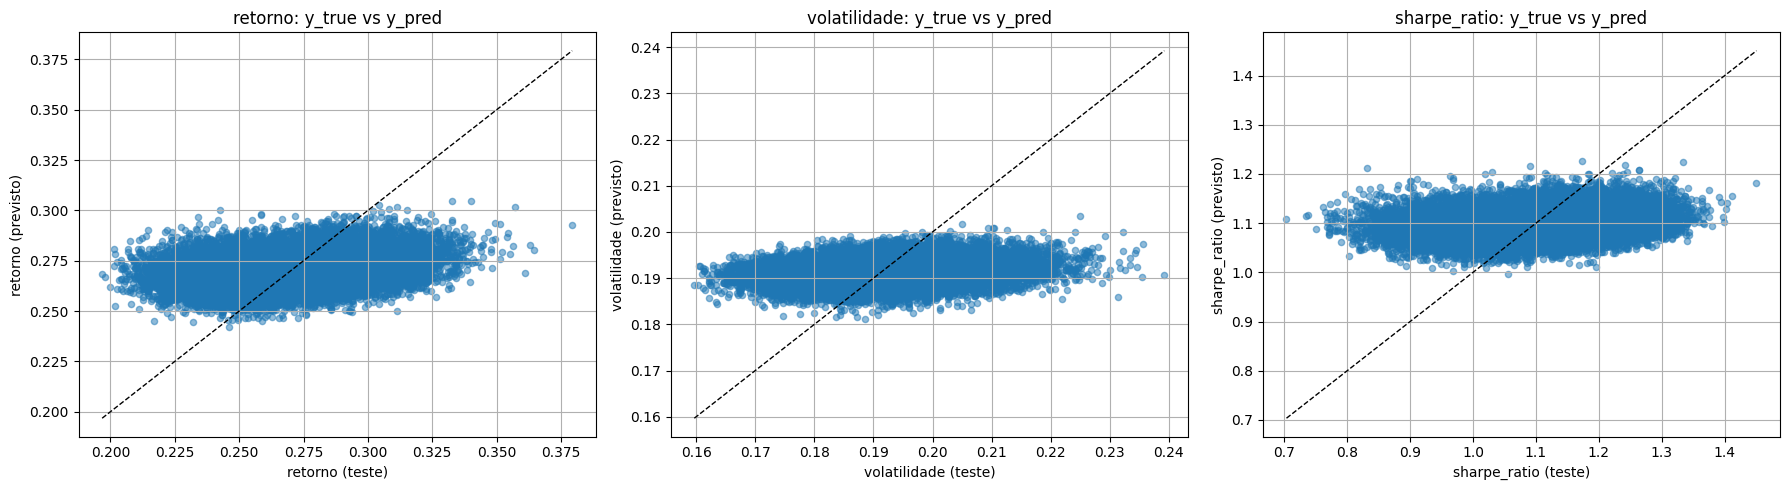

In [57]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 1) checagens rápidas (garante alinhamento)
assert "retorno" in df_treino.columns and "volatilidade" in df_treino.columns and "sharpe_ratio" in df_treino.columns, \
    "df_treino deve conter colunas 'retorno', 'volatilidade', 'sharpe_ratio'"
assert "retorno" in df_teste.columns and "volatilidade" in df_teste.columns and "sharpe_ratio" in df_teste.columns, \
    "df_teste deve conter colunas 'retorno', 'volatilidade', 'sharpe_ratio'"

# Garante que ambos têm a mesma quantidade de observações (mesmas carteiras em mesma ordem)
if len(df_treino) != len(df_teste):
    raise ValueError(f"df_treino e df_teste precisam ter o mesmo número de linhas. got {len(df_treino)} vs {len(df_teste)}")

# 2) Monta X e y (DataFrames)
X = df_treino[["retorno", "volatilidade", "sharpe_ratio"]].copy()
y = df_teste[["retorno", "volatilidade", "sharpe_ratio"]].copy()

# (Opcional) padronização — descomente se quiser normalizar X
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler().fit(X)
# X_scaled = scaler.transform(X)
# X_model = X_scaled
# Neste bloco mantemos X sem escalar:
X_model = X.values
y_model = y.values

# 3) Ajusta regressão linear multivariada (mesma instância prevê os 3 alvos)
modelo = LinearRegression()
modelo.fit(X_model, y_model)   # y_model shape (n_samples, 3)

# 4) Previsões
y_pred = modelo.predict(X_model)

# 5) Métricas por alvo
metricas = {}
alvos = ["retorno", "volatilidade", "sharpe_ratio"]
for i, alvo in enumerate(alvos):
    r2 = r2_score(y_model[:, i], y_pred[:, i])
    mse = mean_squared_error(y_model[:, i], y_pred[:, i])
    mae = mean_absolute_error(y_model[:, i], y_pred[:, i])
    metricas[alvo] = {"r2": r2, "mse": mse, "mae": mae}

# 6) Coeficientes (uma linha por alvo)
# modelo.coef_ tem shape (n_alvos, n_features)
coefs_df = pd.DataFrame(modelo.coef_, columns=["retorno_train", "volatilidade_train", "sharpe_ratio_train"], index=alvos)

# 7) Impressão resumida
print("=== Resumo da Regressão (treino -> teste) ===")
for alvo in alvos:
    print(f"{alvo}: R² = {metricas[alvo]['r2']:.4f} | MSE = {metricas[alvo]['mse']:.6g} | MAE = {metricas[alvo]['mae']:.6g}")
print("\nCoeficientes (linhas = alvo_test, colunas = features do treino):")
print(coefs_df)
print("\nInterceptos por alvo:", modelo.intercept_)

# 8) Plots: y_true vs y_pred para cada métrica (visual sanity-check)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, alvo in enumerate(alvos):
    ax = axes[i]
    ax.scatter(y_model[:, i], y_pred[:, i], alpha=0.5, s=20)
    mn = np.nanmin([y_model[:, i].min(), y_pred[:, i].min()])
    mx = np.nanmax([y_model[:, i].max(), y_pred[:, i].max()])
    ax.plot([mn, mx], [mn, mx], linestyle="--", color="k", linewidth=1)  # linha identidade
    ax.set_title(f"{alvo}: y_true vs y_pred")
    ax.set_xlabel(f"{alvo} (teste)")
    ax.set_ylabel(f"{alvo} (previsto)")
    ax.grid(True)

plt.tight_layout()
plt.show()
# ---------------------------
# Fim do bloco de regressão
# ---------------------------